---
# Estimate closest SSM node to a lat/lon pair

---


In [60]:
import sys
sys.path.insert(1, '../scripts/')
import numpy as np
import geopandas as gpd
from pathlib import Path
from math import radians
import matplotlib.pyplot as plt
from shapely.geometry import Point
from ssm_utils import estimate_nearest_node

In [61]:
from pyproj import Transformer

### identify lat/lon location to evaluate

In [62]:
# BellinghamBay outfall buoy (NOAA Station 46118)
ilat=48.724
ilon=-122.57

### project lat/lon location onto a projection with units of meters

In [63]:
# Kevin's shapefile
root_dir = Path(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/KingCounty-Rachael/'
)
#shapefile_path = root_dir/'kevin_shapefiles/SSMGrid2_060922/SSMGrid2_060922.shp'
shapefile_path = root_dir/'kevin_shapefiles/SSMGrid2_062822/SSMGrid2_062822.shp'

In [64]:
gdf = gpd.read_file(shapefile_path)

In [65]:
gdf.head(1)

,node_id,Basin,uncategori,x,y,x_shp,y_shp,lat,lon,depth,included_i,DO_std,volume,area,Shape_Leng,Shape_Area,geometry
0,1249,SJF_Admiralty,None,380473.98,5365288.5,380500.860294,5.365280e+06,48.429395,-124.615801,160.628998,1,7,1.824350e+09,11357538.53,13249.778795,1.135754e+07,"POLYGON ((378570.860 5364434.875, 378213.530 5..."


#### get shapefile projection and map lat/lon point to projection

In [66]:
shapefile_EPSG = gdf.crs.to_epsg()
shapefile_EPSG

32610

### plotting location lat/lon to shapefile projection

In [67]:
transformer = Transformer.from_crs('WGS84',f'EPSG:{shapefile_EPSG}')
#transformer = Transformer.from_crs('WGS84',f'EPSG:32610')
station_loc_x, station_loc_y=transformer.transform(ilat,ilon) 

### model grid lat/lon to shapefile projection

In [68]:
ssm_x,ssm_y=transformer.transform(gdf.lat,gdf.lon) 

### Evaluate max difference between transformed lat/lon and provided x-,y-

In [69]:
max(abs(ssm_x-gdf.x))

0.003832331334706396

In [70]:
max(abs(ssm_y-gdf.y))

0.000744297169148922

###### That's small enough for me! 

### Apply pythagorean theorem to find nearest node

In [71]:
[n_nodes,n_attrs]=gdf.shape
distance=(np.ones((n_nodes))*station_loc_x - ssm_x)**2 + \
         (np.ones((n_nodes))*station_loc_y - ssm_y)**2
          
# distance=(np.ones((16012,2))*station_loc_xy[:,0]-(np.ones((2,16012))*node_info['x'][:].values).T)**2+(np.ones((16012,2))*station_loc_xy[:,1]-(np.ones((2,16012))*node_info['y'][:].values).T)**2

In [72]:
np.nanmin(distance)

81395.62837201153

In [73]:
#find the closest node index (find the minimum distance between the interested locations and node locations)
closest_node_index=(distance==np.nanmin(distance))

In [74]:
node_id=gdf.node_id[closest_node_index].item()
print(node_id)

6367


In [75]:
index=gdf.index[closest_node_index].item()
print(index)

1455


In [76]:
gdf.node_id[closest_node_index]

1455    6367
Name: node_id, dtype: int64

In [77]:
gdf_nearest=gdf.loc[gdf.node_id==node_id]
gdf_nearest

,node_id,Basin,uncategori,x,y,x_shp,y_shp,lat,lon,depth,included_i,DO_std,volume,area,Shape_Leng,Shape_Area,geometry
1455,6367,SOG_Bays,None,531651.81,5397148.1,531662.461145,5.397147e+06,48.726553,-122.569609,11.86,1,6,40221884.54,3391389.928,7196.201856,3.391390e+06,"POLYGON ((532321.968 5396362.171, 532026.061 5..."


/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/.conda/envs/klone_jupyter/lib/python3.10/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/tmp/ipykernel_49601/2367208346.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(xlabels,rotation=45)


[Text(520000.0, 0, '300000'),
 Text(522500.0, 0, '350000'),
 Text(525000.0, 0, '400000'),
 Text(527500.0, 0, '450000'),
 Text(530000.0, 0, '500000'),
 Text(532500.0, 0, '550000'),
 Text(535000.0, 0, '600000'),
 Text(537500.0, 0, ''),
 Text(540000.0, 0, '')]

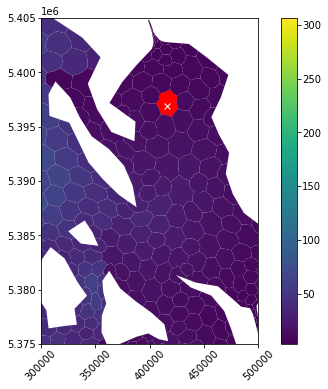

In [78]:
ssm_x_pt,ssm_y_pt = ssm_x[closest_node_index], ssm_y[closest_node_index]
ssmloc = [Point(xy) for xy in zip(ssm_x,ssm_y)]
fig, axs = plt.subplots(1,1, figsize = (8,6))
gdf.plot('depth', ax=axs, legend=True)
# Plot polygon of resulting location
gdf_nearest.plot('node_id',ax=axs,color='red',legend=False)
# Plot point using shapefile projection
axs.plot(station_loc_x,station_loc_y, 'xw')
# Zoom into Bbay so we can actualy see overlap
axs.set_ylim(5.375e6,5.405e6)
axs.set_xlim(5.2e5,5.4e5)
xlabels=axs.get_xticklabels()
axs.set_xticklabels(xlabels,rotation=45)

## Take a stab at creating a function 

In [79]:
def find_closest_node(lats,lons,shapefile):
    """
    INPUTS:
    - lats: single value or vector of values 
    - lons: single value or vector of values
    - shapefile: path and .shp file name, combined
    OUTPUTS:
    - node_id: SSM node corresponding to specified lat/lon pair(s), and same length as input 
    - index: dataframe row index for nodes.  Same length as input. 
    - station_x, station_y: projected lat/lon station locations (for graphing purposes)
    """
    # load shapefile
    gdf = gpd.read_file(shapefile)
    # get shapefile projection information
    shapefile_EPSG = gdf.crs.to_epsg()
    # create transformation from WGS84 to shapefile projection
    transformer = Transformer.from_crs('WGS84',f'EPSG:{shapefile_EPSG}')
    # transform lat(s) and lon(s) to shapefile projection (in meters)
    stations_y, stations_x=transformer.transform(lats, lons) 
    # create vector of SSM model lats and lons projected to shapefile projection (in meters)
    ssm_y, ssm_x=transformer.transform(gdf.lat, gdf.lon) 
    # calculate distance(s) between lat/lon location(s) and model nodes
    [n_nodes,n_attrs]=gdf.shape
    index=[]
    node_id=[]
    try: # for array of station locations
        # find nearest node index and ID
        for idx in range(0,len(stations_y)):
            distance=(np.ones((n_nodes))*stations_x[idx] - ssm_x)**2 + \
                     (np.ones((n_nodes))*stations_y[idx] - ssm_y)**2  
            #create boolean vector with True for node with the closest node index (find the minimum distance between the interested locations and node locations)           
            closest_node_index=(distance==np.nanmin(distance))
            # get index where True
            index.append(np.where(closest_node_index)[0].item())
            # identify nearest SSM node ID(s) to lat/lon locations 
            node_id.append(gdf.node_id[closest_node_index].item())
            
    except: # for single station location
        distance=(np.ones((n_nodes))*stations_x - ssm_x)**2 + \
                  (np.ones((n_nodes))*stations_y - ssm_y)**2 
        #create boolean vector with True for node with the closest node index (find the minimum distance between the interested locations and node locations)
        closest_node_index=(distance==np.nanmin(distance))
        # get index where True
        index.append(np.where(closest_node_index)[0].item())
        # identify nearest SSM node ID(s) to lat/lon locations 
        node_id.append(gdf.node_id[closest_node_index].item())
    return node_id,index,stations_x, stations_y

## Now let's try with many points
- BBay outfall buoy, NOAA Station 46118 (48.724, -122.57)
- Ecology low DO location in BBay...as my guestimate on location (48.767422,-122.575792)
- Birch Bay WWTP outfall...as my guestimate on location (48.898880, -122.781905) and/or 
  (48.895273,-122.805067) for location ~2,000 ft off Point Whitehorn
- Cherry Point aquatic reserve (48.868451, -122.780400)
- Eastsound (48.684406, -122.898953)

In [80]:
station_id=[
    'NOAA Station 46118', 
    'BHAM-Bay Low DO', 
    'Birch Bay', 
    'Birch Bay (Point Whitehorn)',
    'Cherry Point', 
    'Eastsound']
station_lat=np.array([48.724, 48.767422, 48.898880, 48.895273, 48.868451, 48.684406])
station_lon=np.array([-122.57, -122.575792, -122.781905, -122.805067, -122.780400, -122.898953])

In [81]:
node_id, df_index, st_x, st_y = find_closest_node(station_lat, station_lon, shapefile_path)

In [82]:
node_id

[6367, 6567, 5845, 5844, 5615, 5212]

In [83]:
df_index

[1455, 1545, 1256, 1255, 1166, 976]

In [84]:
len(ssm_pt)

6

## Plot up the results!

/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/.conda/envs/klone_jupyter/lib/python3.10/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/tmp/ipykernel_49601/440955641.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(xlabels,rotation=45)


[Text(500000.0, 0, '300000'),
 Text(505000.0, 0, '350000'),
 Text(510000.0, 0, '400000'),
 Text(515000.0, 0, '450000'),
 Text(520000.0, 0, '500000'),
 Text(525000.0, 0, '550000'),
 Text(530000.0, 0, '600000'),
 Text(535000.0, 0, ''),
 Text(540000.0, 0, '')]

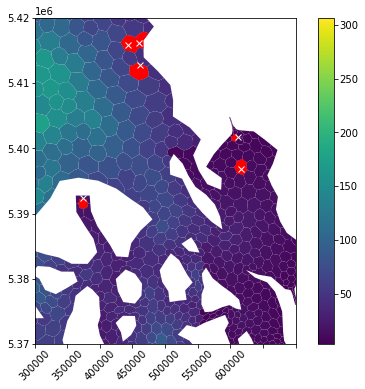

In [85]:
# sub-sample geodataframe with just the selected nodes
gdf_nearest=gdf.loc[gdf.node_id.isin(node_id)]

fig, axs = plt.subplots(1,1, figsize = (8,6))
gdf.plot('depth', ax=axs, legend=True)
# Plot polygon of resulting location
gdf_nearest.plot('node_id',ax=axs,color='red',legend=False)
# Plot point using shapefile projection
for xy in zip(st_x,st_y):
    axs.plot(xy[1], xy[0], 'xw')
# Zoom into Bbay so we can actualy see overlap
axs.set_ylim(5.37e6,5.42e6)
axs.set_xlim(5e5,5.4e5)
xlabels=axs.get_xticklabels()
axs.set_xticklabels(xlabels,rotation=45)

## Everything below this point is development "notes"

In [14]:
# Kevin's shapefile
root_dir = Path(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/KingCounty-Rachael/'
)
shapefile_path = root_dir/'kevin_shapefiles/SSMGrid2_060922/SSMGrid2_060922.shp'

    
nearest_node = estimate_nearest_node(shapefile_path,ilat,ilon)


0


/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/.conda/envs/klone_jupyter/lib/python3.10/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


In [15]:
from shapely.geometry import Point
from pyproj import CRS
# load shapefil
gdf = gpd.read_file(shapefile_path)
# project lat/lon to shapefile coordinate
iloc = [Point(xy) for xy in zip([ilon],[ilat])]
crs = CRS('epsg:6318')
geo_df_iloc = gpd.GeoDataFrame(geometry = iloc, crs = crs)
geo_df_iloc = geo_df_iloc.to_crs(crs = gdf.crs)

# find nearest polygon to point
polygon_index = [poly.distance(geo_df_iloc) for poly in gdf]
gdf.loc[polygon_index]

AttributeError: 'str' object has no attribute 'distance'

In [24]:
geo_df_iloc['geometry']

0    POINT (-13644429.987 6228159.068)
Name: geometry, dtype: geometry

In [13]:
gdf.head(2)

,node_id,Basin,uncategori,x,y,lat,lon,depth,included_i,DO_std,volume,area,Shape_Leng,Shape_Area,geometry
0,1249,SJF_Admiralty,None,380473.98,5365288.5,48.429395,-124.615801,160.628998,1,7,1.824350e+09,1.135754e+07,19963.958367,2.578675e+07,"POLYGON ((-13875002.725 6177241.606, -13875563..."
1,1336,SJF_Admiralty,None,381900.00,5361920.0,48.399371,-124.595583,128.695007,1,7,1.030327e+09,8.005960e+06,16094.802435,1.815623e+07,"POLYGON ((-13871902.847 6172073.657, -13872526..."


In [19]:
geo_df_iloc.distance(gdf)

/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/.conda/envs/klone_jupyter/lib/python3.10/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


0       229844.438898
1                 NaN
2                 NaN
3                 NaN
4                 NaN
            ...      
7489              NaN
7490              NaN
7491              NaN
7492              NaN
7493              NaN
Length: 7494, dtype: float64

In [15]:
[poly.distance(geo_df_iloc) for poly in gdf['geometry']]

AttributeError: 'GeoDataFrame' object has no attribute '_geom'

In [8]:
polygon_index

0

In [7]:
geo_df_iloc

,geometry
0,POINT (-13644429.987 6228159.068)


## Load shapefiles

In [4]:
root_dir = Path(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/KingCounty-Rachael/'
)
shapefile_path = root_dir/'kevin_shapefiles/SSMGrid2_060922/SSMGrid2_060922.shp'
gdf = gpd.read_file(shapefile_path)
gdf.head(2)

,node_id,Basin,uncategori,x,y,lat,lon,depth,included_i,DO_std,volume,area,Shape_Leng,Shape_Area,geometry
0,1249,SJF_Admiralty,None,380473.98,5365288.5,48.429395,-124.615801,160.628998,1,7,1.824350e+09,1.135754e+07,19963.958367,2.578675e+07,"POLYGON ((-13875002.725 6177241.606, -13875563..."
1,1336,SJF_Admiralty,None,381900.00,5361920.0,48.399371,-124.595583,128.695007,1,7,1.030327e+09,8.005960e+06,16094.802435,1.815623e+07,"POLYGON ((-13871902.847 6172073.657, -13872526..."


In [5]:
gdf.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
gdf_pt = gdf.loc[gdf['node_id']==nearest_node]
gdf_pt

,node_id,Basin,uncategori,x,y,lat,lon,depth,included_i,DO_std,volume,area,Shape_Leng,Shape_Area,geometry
0,1249,SJF_Admiralty,None,380473.98,5365288.5,48.429395,-124.615801,160.628998,1,7,1.824350e+09,11357538.53,19963.958367,2.578675e+07,"POLYGON ((-13875002.725 6177241.606, -13875563..."


In [16]:
print(nearest_node)
print(gdf['node_id']==nearest_node)

1249
0        True
1       False
2       False
3       False
4       False
        ...  
7489    False
7490    False
7491    False
7492    False
7493    False
Name: node_id, Length: 7494, dtype: bool


In [15]:
ssmlon,ssmlat = gdf['lat'][gdf['node_id']==nearest_node], gdf['lon'][gdf['node_id']==nearest_node]
print(ssmlon,ssmlat)


0    48.429395
Name: lat, dtype: float64 0   -124.615801
Name: lon, dtype: float64


In [9]:
from shapely.geometry import Point
from pyproj import CRS
ssmlon,ssmlat = gdf['lat'][gdf['node_id']==nearest_node], gdf['lon'][gdf['node_id']==nearest_node]
ssmloc = [Point(xy) for xy in zip(ssmlon,ssmlat)]
iloc = [Point(xy) for xy in zip([ilon],[ilat])]
crs = CRS('epsg:6318')
geo_df_ssmloc = gpd.GeoDataFrame(geometry = ssmloc, crs = crs)
geo_df_iloc = gpd.GeoDataFrame(geometry = iloc, crs = crs)


In [10]:
geo_df_ssmloc=geo_df_ssmloc.to_crs(crs = gdf.crs)
geo_df_iloc=geo_df_iloc.to_crs(crs = gdf.crs)
gdf=gdf.set_crs(crs=gdf.crs)

<AxesSubplot:>

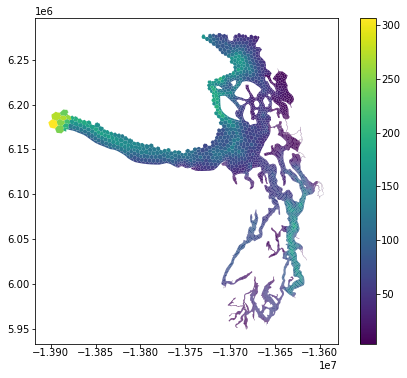

In [13]:
import matplotlib.pyplot as plt
gdf_pt = gdf.loc[gdf['node_id']==nearest_node]
fig, axs = plt.subplots(1,1, figsize = (8,6))
gdf.plot('depth', ax=axs, legend=True)
# plot the marker
geo_df_ssmloc.plot(ax = axs, markersize = 20, color = 'red',marker = '*',label = 'SSM', zorder=3)
#geo_df_iloc.plot(ax = axs, markersize = 10, color = 'green',marker = 'o',label = 'plot location', zorder=3)

In [ ]:
node = np.array(gdf['node_id'])
ssmlat,ssmlon = gdf['lat'].values, gdf['lon'].values
ilat = 46.235
ilon = -123.872
dlat = np.radians(ssmlat - ilat)
dlon = np.radians(ssmlon - ilon)

### Haversine

In [11]:
r = 6367 # approx. radius of earth in km
d = (np.sin(dlat/2)**2) + np.cos(ilat)*np.cos(ssmlat)*(np.sin(dlon/2))**2
dist = 2*r*np.arcsin(np.sqrt(d))

In [12]:
nearest_node = node[dist == min(dist)].item()

In [13]:
print(ssmlat[node==nearest_node], ssmlon[node==nearest_node])

[47.09745529] [-123.0779051]


In [14]:
110*(47.09745529-46.235)

94.87008189999997

In [15]:
min(dist)

118.70875148011876